In [225]:
# Notebook for our experiemnt on slabs
"""The value of index n can be extracted by comparing the M(theta) data with functional shapes 
computed for a set of candidate n-values."""

'The value of index n can be extracted by comparing the M(theta) data with functional shapes \ncomputed for a set of candidate n-values.'

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import os

In [227]:
# T = 1e-3 # thickness of slab in mm
n = 1.5 # guess of index of refraction
lambda_HeNe = 632.99e-9 # wavelength of laser in nm (vacuum)

In [330]:
# Defining functions we will use later

def get_n(theta, M, T):
    """Function to get index of refraction; from TeachSpin article Chap 11-5"""
#     Converting theta to radians (fed in in degrees)
    theta_rad = (theta *np.pi) / 180
    
    
    alpha = (M * lambda_HeNe)/ (2*T)
    n = ((alpha**2) + 2 *((1 - np.cos(theta_rad))*(1-alpha))) / (2*(1 - np.cos(theta_rad) - alpha))
    return n
    
def getM(x, n, T):
    """Function to get the fringe count M as a function of theta
        function shape depends on thickness T and index of refraction of the slab"""
    M = (2 * T * (n-1) * (x **2))/(lambda_HeNe * 2*n)
    
    return M


def quadModel(x,a,b,c):
#     fucntion to return a quadratic fit: ax**2 + b
    return a*(x**2) + b*x + c

def errorSquare(x,a,sigma_a, y=2):
#     Error propagation of param a with relationship x = a^y (a takes the place of theta here)
    if a != 0:
        sigma_x = y*x * (sigma_a/a)
        return sigma_x
    
    elif a ==0:
        return 0

# ######################################################################################################

def makePlots(filename):
    '''Function that replaces the blocks of code written below.
        Takes in filename, reads file and then fixes data (sums counts, resets max, etc.),
        plots datas along with quadratic fit which we are using for '''
    
    path = '/Users/andrewbowen/OpticsLab/Interferometry/slabs/data/'
    data = pd.read_csv(path + filename)
    
#     Summing up counts, comment out if did not reset in between data runs
    new_counts = []
    c=0
    for index,row in data.iterrows():
    
        c += row['Counts (M)']
        new_counts.append(c)
    
#     Might need to recalibrate data to where we are perpendicular (was -5deg in one test)
    data['new counts'] = new_counts
    print(data)
    
    print('')
    print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
    print('')
    
    theta = data['theta (deg)']
    theta_err = data['theta_err (deg)']
    counts = data['new counts'] #/2

    fitCoeffs, fitCovariances = curve_fit(quadModel, theta, counts)
    
    # Bestfit params for our quadratic 
    bestfit_a = fitCoeffs[0]
    bestfit_b = fitCoeffs[1]
    bestfit_c = fitCoeffs[2]   
    print(f'The bestfit for fit param a is: {bestfit_a}')
    print(f'The bestfit for fit param b is: {bestfit_b}')
    print(f'The bestfit for fit param c is: {bestfit_c}')

    print('')
    print('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #')
    print('')    
# ############################################################################################

#     Determining error values in M, will depend on error in theta and thickness (0.1mm)

    sigmaT = 1e-4
    errT = (sigmaT / 0.5e-3)**2
    theta_err_rad = (theta_err * np.pi) / 180
    errM = [errorSquare(m, t,sig,2) for m,t,sig in zip(counts, theta, theta_err_rad)]
    print('Error Values for M: ', errM)
# ############################################################################################
    
#     Creating quadratic fit, input array of theta values with fitted array (quad)
    theta_input = np.arange(np.min(theta),np.max(theta))
    quad = quadModel(theta_input, bestfit_a, bestfit_b, bestfit_c) # array of model quadratic, to plot later
#     print('Model: ',quad)
    
    # Plotting counts versus theta (angle relative to start)
    f,ax = plt.subplots()
    ax.errorbar(theta, counts, xerr = theta_err, yerr = errM,fmt = 'o')
    ax.set_xlabel(r'$\theta$ (deg)', fontsize = 16)
    ax.set_ylabel('Counts, M',fontsize = 16)

    # Plotting quadratic fit model calculated above
    ax.plot(theta_input, quad, c = 'r')
    ax.set_title('Test ' + filename[24], fontsize = 16)
    
#     Getting index of refraction n from our fit parameters - 
#     borrowed from Prof. Kovachy's Mathematica code & Teachspin manual pg 69 (nice.)  
    index = 1/(1-((abs(bestfit_a) * lambda_HeNe)/0.5e-3))
    print('Model index of refraction (n): ', index)
    

   theta (deg)  theta_err (deg)  Counts (M)  new counts
0          -20              2.5           0         0.0
1          -15              2.5          55        55.0
2          -10              2.5          39        94.0
3           -5              2.5          20       114.0
4            0              2.5          -2       112.0
5            5              2.5         -24        88.0
6           10              2.5         -37        51.0
7           15              2.5         -75       -24.0
8           20              2.5         -64       -88.0

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

The bestfit for fit param a is: -0.39311688311992166
The bestfit for fit param b is: -2.3366666666739437
The bestfit for fit param c is: 110.18614718638533

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

Error Values for M:  [-0.0, -0.31997702953229373, -0.8203047484373349, -1.9896753472735358, 0, 1.53588974175501, 0.44505

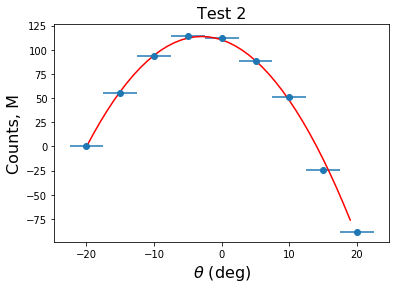

In [331]:
# Test call
makePlots('slab-Index-of-Refraction2.csv')

   theta (deg)  theta_err (deg)  Counts (M)  new counts
0            0                2           0           0
1            5                2       99989       99989
2           10                2       99964      199953
3           15                2       99946      299899
4           20                2       99947      399846
5           25                2       99810      499656
6           30                2          74      499730
7           35                2         154      499884
8           40                2          64      499948
#################################################
The bestfit for the param a is: -389.1412998211661
The bestfit for the param b is: 28894.945322029
The bestfit for the param c is: -24173.836521541398
   theta (deg)  theta_err (deg)  Counts (M)  new counts
0          -20              2.5           0         0.0
1          -15              2.5          55        55.0
2          -10              2.5          39        94.0
3           -5 

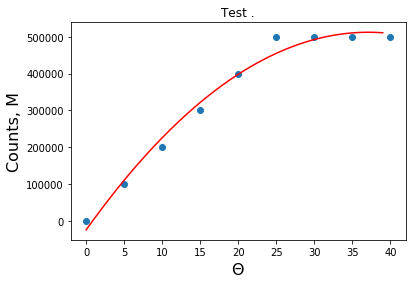

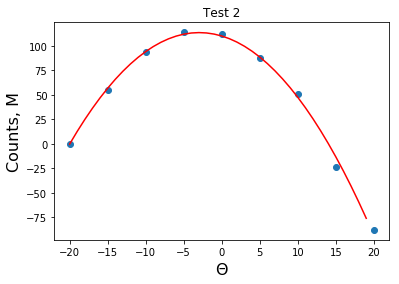

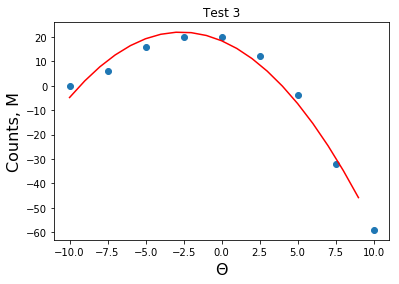

In [254]:
# Walking through entire slabs data directory and creating plots for each trial
for file, root,names in os.walk(path, topdown = True):
    for name in names:
        makePlots(name)